In [39]:
# Kishen Patil
# Simulating and Benchmarking IBM's Brisbane QPU
# August 14 2025


import logging
# Suppress all logging from stevedore (which is needed with QISKIT 2.0 for some reason...)
logging.getLogger("stevedore.extension").propagate = False
logging.getLogger("stevedore.extension").disabled = True

# Importing All of the Tools

In [40]:
try:

  import qiskit
  print('Qiskit imported')

except ImportError:

  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  # !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

import qiskit
print('Qiskit version:', qiskit.__version__)

try:

  from qiskit_aer import QasmSimulator
  print('Qiskit Aer imported');

except ImportError:

  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer

try:

  from qiskit_ibm_runtime import QiskitRuntimeService
  print('Qiskit-IBM-Runtime imported')

except ImportError:

  print('Install Qiskit-IBM-Runtime')
  !pip install --quiet qiskit-ibm-runtime
  !pip install --quiet qiskit_ibm_provider[visualization]

%matplotlib inline
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

'''
#QuTiP imports
import qutip as qt
from qutip import *

#QUTIP QIP
from qutip.qip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate
from qutip_qip.qasm import circuit_to_qasm_str
'''

#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler


'''
In Jupyter Notebooks we can display this nicely using Latex.
'''
from qiskit.visualization import array_to_latex

from scipy import constants


Qiskit imported
Qiskit version: 2.1.1
Qiskit Aer imported
Qiskit-IBM-Runtime imported


# Setup Transpile

In [41]:
##################### set up transpile ######################

# Create circuit to test transpiler on
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

tok = '' # my unique token to access IBM Brisbane

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
  token = tok,
  channel = "ibm_quantum_platform", # `channel` distinguishes between different account types
  overwrite = True,
  set_as_default = True
)

service = QiskitRuntimeService()

backend = service.backend("ibm_brisbane"); # use Brisbane QPU

initLayout = [];
pass_manager = generate_preset_pass_manager(optimization_level = 0, backend = backend, seed_transpiler = 0, initial_layout = initLayout); # initialize the QPU


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-15 16:46:17,860: Default instance not set. Searching all available instances.


# Measuring T1 Time

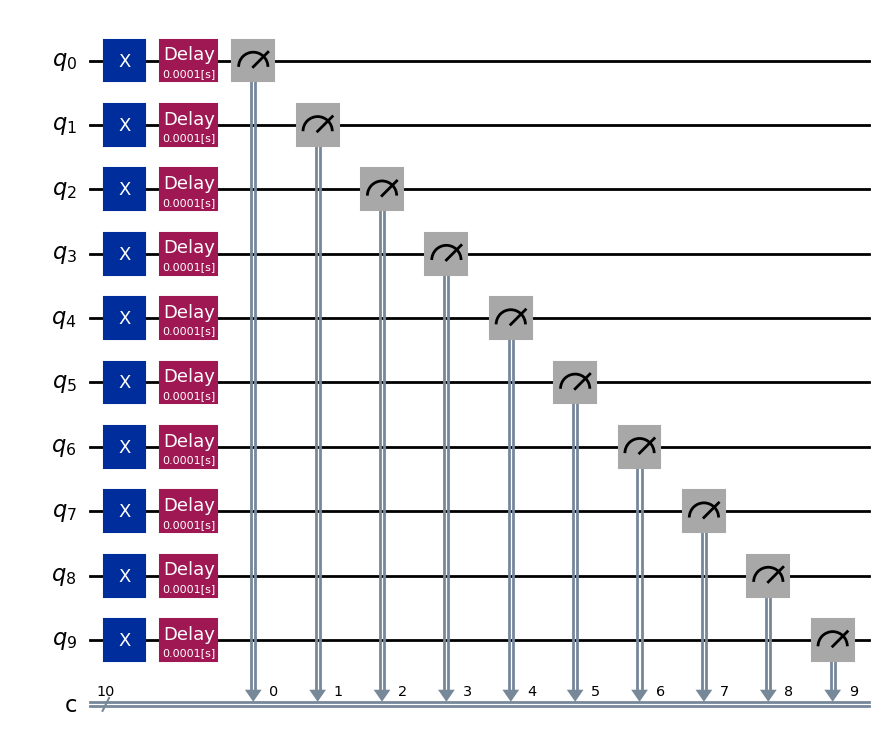

In [47]:
# T1 decay function
# the T1 time is a measure of how long the qubit can stay in its excited state (i.e. how long it can stay in |1>)


# T2 time is called the 'dephasing time'. This is a measure of how long a qubit can stay in a specific state before external sources affect its behavior.
# This is important because if the qubit is not manipulated quickly enough (i.e. gate operations) then you risk losing its state and thus you lose information.
# As is common in quantum mechanics, once information has been lost it is very difficult to recreate it. A longer T2 time means your qubit can withstand affects from external sources. Essentially its a measure of resiliency of the qubit.

def exp_decay(t, A, T1, B):
    return A * np.exp(-t / T1) + B

# Parallel T1 circuit generator, this will be used to measure the T1 time of a qubit
def parallel_t1(delay, num_qubits):

    qc = QuantumCircuit(num_qubits, num_qubits) # initialize a quantum circuit

    for q in range(num_qubits):
        qc.x(q)  # flip the qubit into the excited state
        qc.delay(delay, q, unit="s")  # wait
        qc.measure(q, q) # measure the qubit

    return qc

qc = parallel_t1(delay = 100e-6, num_qubits = 10) # set up the T1 circuit
qc.draw('mpl')

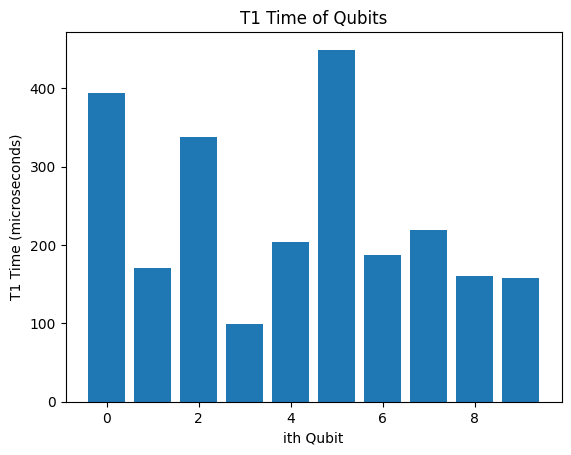

In [77]:
######################### Measuring the T1 time of Qubits (1) #########################

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane()
backend.refresh(service)

#backend = service.backend("ibm_brisbane"); # use the brisbane QPU

nQubits = 10  # 10 qubits
shots = 1000 # number of times to execute the quantum circuit

delays_us = np.array([1, 50, 100, 200, 300, 400 ,500 ] ) # delay time (microseconds)
delay_times = 1e-6 * delays_us  # delay time (seconds)

# Run circuits and collect data
probs_per_qubit = {q: [] for q in range(nQubits)}

for Delay in delay_times: # for each delay time

    sampler = Sampler(mode = backend);

    qc = parallel_t1(delay = Delay, num_qubits = nQubits) # set up the T1 circuit

    transpiled = transpile(qc, backend, scheduling_method = "alap") # transpile the circuit so that it is compatible to run on my chosen QPU
    job = sampler.run([transpiled], shots = shts) # run the circuit
    result = job.result() # get the measured outputs

    counts = result[0].data.c.get_counts() # a dictionary of all the counts of every state


    for qubit in range(nQubits): # iterate through all the qubits

        one_count = 0 # counter to keep track of how many times thi qubit is in the |1> state

        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1': # if this qubit was in the |1> state
                one_count = one_count + count # increment the |1> state count for this qubit

        probs_per_qubit[qubit].append(one_count / shots) # store the probability of the ith qubit being in |1> state in  a list


t1_estimates = {} # keep a record of the T1 times for every qubit

for q in range(nQubits):
    try:
        popt, _ = curve_fit( # fits T1 times for every qubit (averaging T1 times based on different delay times for every qubit)
            exp_decay,
            delays_us,
            probs_per_qubit[q],
            p0 = [0.9, 50, 0.1])

        t1_estimates[q] = popt  # Save all the measured T1 times

    except RuntimeError:
        t1_estimates[q] = None

for n in range(nQubits): # iterate through all of the qubits

    params = t1_estimates[n]

    if params is not None:

      t1_estimates[n] = max(params) # extract only the maximu T1 times

    else:
      t1_estimates[n] = 0; # if the measurement does not exist, just set its time to 0


x = np.arange(nQubits)

plt.figure();
plt.xlabel("ith Qubit")
plt.ylabel("T1 Time (microseconds)")
plt.title("T1 Time of Qubits")

plt.bar(x, t1_estimates.values())
plt.show()

# Measuring T2 Time

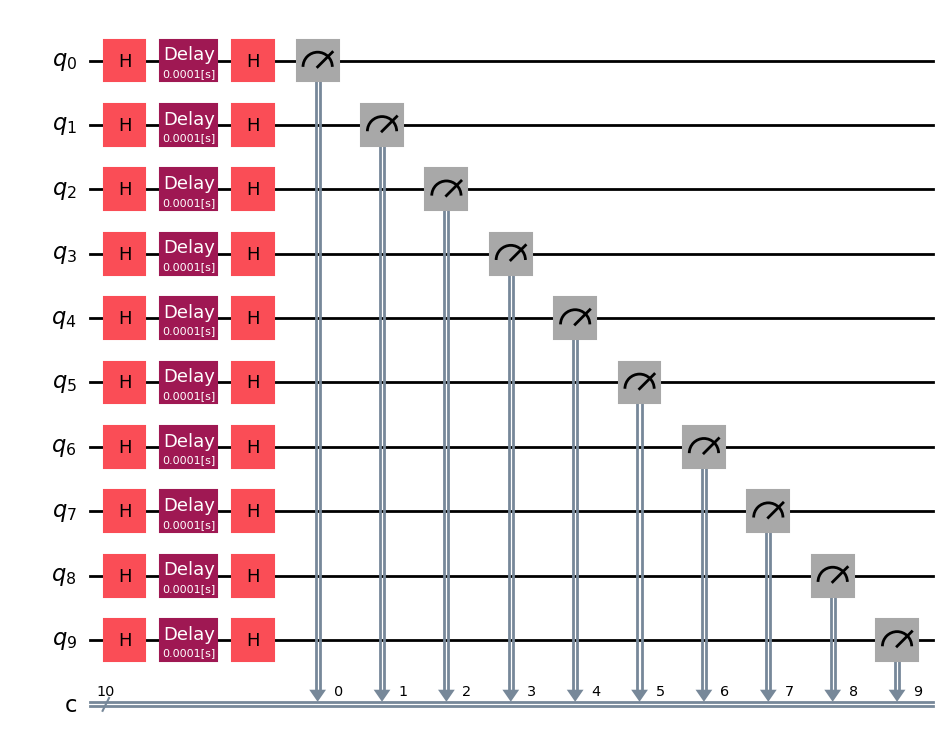

In [48]:
# Define exponential decay function
def exp_decay(t, A, T2, B):
    return A * np.exp(-t / T2) + B


# Parallel Ramsey function
def parallel_Ramsey(delay, num_qubits):

    qc = QuantumCircuit(num_qubits, num_qubits)

    for q in range(num_qubits):
        # qc.x(q)
        qc.h(q) # put qubit in |+>
        qc.delay(delay , q, unit="s") # wait for some time
        qc.h(q) # put qubit back into |0>
        qc.measure(q, q) # measure the qubit

    return qc

  # if the qubit in the Ramsey circuit does not revert back to |0>, then there was some decoherence. If the delay is longer and you can still manage to get back to |0> after the 1st H gate, then you have a longer T2 time.
  # Decoherence happens in the X / Y basis because that is where the relative phase information is stored. So if something were to affect the relative phase, then it brought the qubit into a decoherent state.

qc = parallel_Ramsey(delay = 100e-6, num_qubits = 10) # set up the Ramsey circuit
qc.draw('mpl')

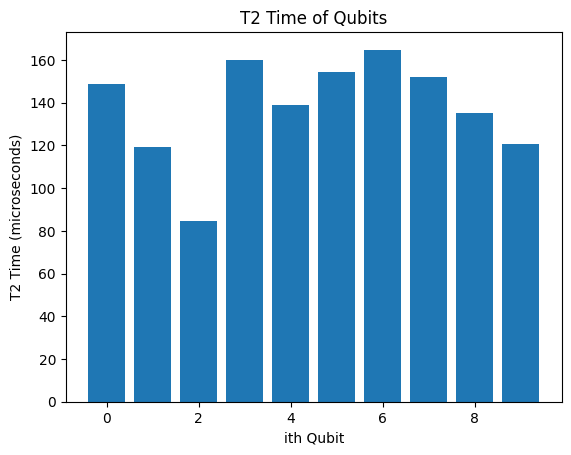

In [78]:
######################### Measuring the T2 time of Qubits (1) #########################

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane()
backend.refresh(service)

#backend = service.backend("ibm_brisbane");

nQubits = 10
shts = 1000

delays_us = [1, 50, 100, 200, 300 ,400, 500]
delay_times = [d * 1.0e-6 for d in delays_us]

# Store probabilities per qubit
probs_per_qubit_Ramsey = {q: [] for q in range(nQubits)}

# Run simulations
for Delay in delay_times:

    sampler = Sampler(mode = backend)

    qc = parallel_Ramsey(delay = Delay, num_qubits = nQubits) # set up T2 quantum circuit
    transpiled = transpile(qc, backend, scheduling_method = "alap") # transpile onto QPU

    job = sampler.run([transpiled], shots = shts) # run the QPU
    result = job.result()
    counts = result[0].data.c.get_counts(); # count all the measured states

    for qubit in range(nQubits):
        one_count = 0
        for bitstring, count in counts.items():
            if bitstring[::-1][qubit] == '1':
                one_count = one_count + count
        prob = 1 - one_count / shts # probability of qubit being in |0> state. You want this to be high
        probs_per_qubit_Ramsey[qubit].append(prob)

# Fit T2 per qubit and store estimates
t2_estimates = {}

for q in range(nQubits):

    try:
        # Initial parameter guesses and bounds
        popt, _ = curve_fit(
            exp_decay,
            delays_us,
            probs_per_qubit_Ramsey[q],
            p0=[0.5, 50, 0.5],
            bounds=([0.5, 0, 0.5], [0.51, 1000, 0.51])
        )
        t2_estimates[q] = popt  # Store full fit parameters

    except RuntimeError:
        t2_estimates[q] = None


for n in range(nQubits):

    params = t2_estimates[n]
    if params is not None:
      t2_estimates[n] = max(params)
    else:
      t2_estimates[n] = 0;


x = np.arange(nQubits)

plt.figure();
plt.xlabel("ith Qubit")
plt.ylabel("T2 Time (microseconds)")
plt.title("T2 Time of Qubits")

plt.bar(x, t2_estimates.values())
plt.show()

# Showing Parity Oscillations Between GHZ States

In [ ]:
######################### Parity Probabilities with Multiple Qubits (1) #########################

def create_ghz_circuit(num_qubits, phi): # GHZ state is a state with 3 or more qubits. An Odd state is when there is an odd count of |1>. An even state is when there is an even count of |1>

    from numpy import pi

    qc = QuantumCircuit(num_qubits, num_qubits)


    '''Initial Superposition'''
    qc.h(0) # put in |+>

    '''CNOTs to generate Entanglement'''
    for i in range(num_qubits - 1):

        qc.cx(i, i + 1) # control-NOT gate. qi is control, q(i + 1) is target

    qc.barrier()

    for i in range(num_qubits):
        qc.u(qubit = i, theta = pi / 2 , phi = phi, lam = -phi) # add a phase gate. Theta = zenith angle, phi = relative phase

    qc.barrier()


    qc.measure(range(num_qubits), range(num_qubits)) # measure the state of all the qubits

    return qc

def parity_probabilities(counts):

    even = 0 # even state counter
    odd = 0 # odd state counter
    total = 0 # total state count (equivalent to number of shots / times you ran the simulation)

    for bitstring, count in counts.items(): # bitstring is the bit string of the state (literally '0000', '0001', '0010', ...). Counts is a tuple with data counts = (bit string, state count of bit string) = (bitstring, count)
        total = total + count # update the total state count

        if bitstring.count('1') % 2 == 0: # if there is an even number of 1's in this state, then it is an even state
            even = even + count # increment the even count

        else: # otherwise here is an odd number of 1's in this state, then it is an odd state
            odd = odd + count # increment the odd count

    p_even = even / total # probability of even parity
    p_odd = odd / total # probbaility of odd parity
    return p_even, p_odd


def run_parity_oscillations(num_qubits, num_shots, num_points):
    """
    Sweep over phi values and measure parity using FakeBrisbane.
    """
    phi_vals = np.linspace(0, 2 * np.pi, num_points) # iterate over [0, 2*pi]
    p_even_vals = [] # track probability of even parity
    p_odd_vals = [] # track probability of odd parity

    for phi in phi_vals:

        sampler = Sampler(mode = backend); # initialize

        qc = create_ghz_circuit(num_qubits, phi)
        tqc = transpile(qc, backend, scheduling_method = "alap") # transpile the Quantum circuit to the QPU

        job = sampler.run([tqc], shots = num_shots) # run the transpiled circuiton the QPU
        result = job.result()
        counts = result[0].data.c.get_counts(); # count all the measured states

        p_even, p_odd = parity_probabilities(counts) # calculate the probability of even, odd states respectively
        p_even_vals.append(p_even) # for this specific value of phi (ie relative phase), add the even probabilites
        p_odd_vals.append(p_odd) # for this specific value of phi (ie relative phase), add the odd probabilities

    return phi_vals, p_even_vals, p_odd_vals # return arrays of even/odd state probabilities

# the goal of the parity oscillation experiment is to visualize the abilty to produce GHZ states as the relative phase within each qubit increases

In [ ]:

#########################################################################################################################################################################################################

########## you dont need to run this code block. it is not part of any experiment. it is soley for testing code. if you run this code block you will unnecessarily use minutes on your IBM QPU ##########

#########################################################################################################################################################################################################


backend = service.backend("ibm_brisbane");

num_qubits = 4;
num_points = 30;
num_shots = 1000;

phi_vals = np.linspace(0, 2 * np.pi, num_points) # iterate over [0, 2*pi]

for phi in phi_vals:

  sampler = Sampler(mode = backend); # initialize the QPU

  qc = create_ghz_circuit(num_qubits, phi) # create the quantum circuit

  tqc = transpile(qc, backend, scheduling_method = "alap") # transpile the Quantum circuit to the QPU

  job = sampler.run([tqc], shots = num_shots) # run the transpiled circuiton the QPU
  result = job.result()
  counts = result[0].data.c.get_counts(); # count all the measured states (this returns a dictionary data structure with the counts of every final state of the quantum circuit)
  # ie counts = {'state 0' : # of 0 states, 'state 1' : number of 1 states, 'state 2' : number of 2 states, ..., 'state 2^n - 1' : number of 2^n - 1 states}

print(counts)



{'0011': 138, '1111': 105, '1100': 140, '0101': 125, '1010': 116, '0111': 8, '1001': 116, '0000': 105, '0110': 106, '1011': 5, '1000': 6, '1110': 9, '0001': 4, '1101': 7, '0100': 7, '0010': 3}


In [ ]:
for bitstring, count in counts.items(): #
  print("state : {S}\t\tParity Count : {B}".format(S = bitstring, B = bitstring.count('1')))


NameError: name 'counts' is not defined

<ipython-input-9-b086209342fe>:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


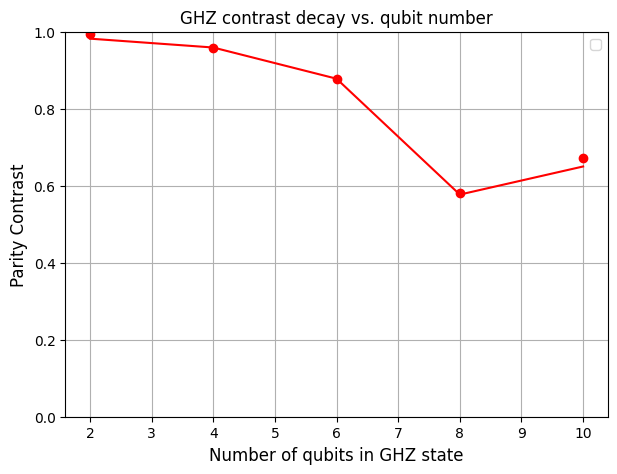

In [ ]:
######################### Parity Probabilities with Multiple Qubits (2) #########################

backend = service.backend("ibm_brisbane");

shts = 1000

# Parity Contrast Data
numQubits = np.array([2, 4, 6, 8, 10])
N = np.shape(numQubits)[0];
#y_vals = np.array([1.0, 0.839, 0.648, 0.515, 0.404])

evenProbs = [];
oddProbs = [];

for q in numQubits:

    phi_vals, p_even_vals, p_odd_vals = run_parity_oscillations(num_qubits = q, num_shots = shts, num_points = 30); # outputs an array of even/odd parities for q qubits

    evenProbs.append(max(p_even_vals)); # take the maximum even state probability and save it
    oddProbs.append(max(p_odd_vals)); # take the maximum odd state probability and save it


del phi_vals; # delete the phi values
del p_even_vals; # delete the even probabilities
del p_odd_vals; # delete the odd probabilities

fs = 12
plt.figure(figsize = (7, 5))
plt.plot(numQubits, evenProbs, 'or')
plt.plot(numQubits, oddProbs, '-r')
plt.xlabel('Number of qubits in GHZ state', fontsize = fs)
plt.ylabel('Parity Contrast', fontsize = fs)
plt.title('GHZ contrast decay vs. qubit number', fontsize = fs)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

del evenProbs;
del oddProbs;

# Quantum Volume Testing

The probability of even / odd state diminishes as you increase both the number of qubits and the relative phase of each qubit.



In [21]:
######################### Quantum Volume (1) #########################

from qiskit.circuit.library import QuantumVolume
from qiskit.quantum_info import Statevector



def create_quantum_volume_circuit(nQubits, Depth):

    qc = QuantumCircuit(nQubits, nQubits)

    qv = QuantumVolume(num_qubits = nQubits, depth = Depth, seed = None, classical_permutation = True, flatten = False) # circuit designed by IBM to measure Quantum Volume

    qc.compose(qv, inplace = True) # add the QV circuit to our test circuit

    qc.barrier()
    qc.measure(range(nQubits), range(nQubits))

    return qc
def compute_heavy_output_prob(ideal_probs, measured_counts):

    # ideal_probs: dictionary data structure logging the probability of each state
    # measured_counts: dictionary data structure logging how many times each state was output

    # 1. Find median of ideal probabilities
    probs = list(ideal_probs.values())
    median = np.median(probs) # get the middle probability

    # 2. Identify heavy output bitstrings
    heavy_outputs = {bit for bit, prob in ideal_probs.items() if prob > median} # list the bits that are most likely to be output (ie above the middle probability)

    # 3. Sum up counts of heavy outputs
    heavy_counts = sum(measured_counts.get(bit, 0) for bit in heavy_outputs) # count how many times each 'heavy output' bit was recorded

    return heavy_counts / shts # probabilities of the most common output bits


def get_ideal_qv_distribution(circuit):
    """
    Simulates the ideal output probability distribution of a QV circuit.
    """
    # Remove measurements for pure statevector simulation
    qc = circuit.remove_final_measurements(inplace = False)

    # Simulate the statevector
    state = Statevector.from_instruction(qc)

    # Get probabilities of measuring each computational basis state
    probs = state.probabilities_dict()

    # Sort keys for consistency
    sorted_probs = {k: probs[k] for k in sorted(probs.keys())}

    return sorted_probs

def get_real_qv_distribution(circuit):
    """
    Simulates the real output probability distribution of a QV circuit.
    """

    from qiskit_ibm_runtime import Sampler
    from qiskit_ibm_runtime.fake_provider import FakeBrisbane

    '''
    from qiskit_ibm_runtime import QiskitRuntimeService
    service = QiskitRuntimeService(channel = "ibm_quantum_platform")
    backend = service.backend("ibm_brisbane")

    '''


    backend = FakeBrisbane() # use the fake QPU for testing
    backend.refresh(service)

    sampler = Sampler(mode = backend)
    transpiled_circuit = transpile(circuit, backend, scheduling_method = "alap")
    job = sampler.run([transpiled_circuit], shots = 1000)

    result = job.result()
    counts = result[0].data.c.get_counts();

    return counts




--- Running QV for 2 qubits/depth ---


/tmp/ipython-input-2638763429.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(state_probabilities.get(bit, 0) for bit in heavy_outputs); # count the number of times each heavy output bit was recorded


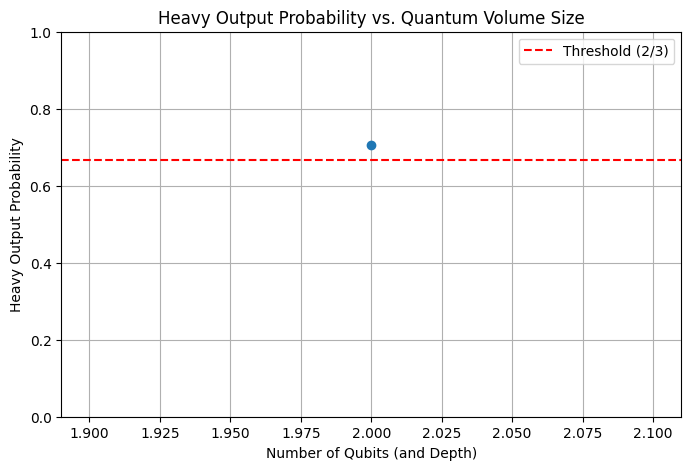

In [ ]:
###################### test code ######################

nQubits = 2; # number of qubits
heavy_output_probs = []; # keep track of the heavy output probabilities
shots = 1000; # run the circuit 1000 times

for n in range(2, nQubits + 1):
    print(f"\n--- Running QV for {n} qubits/depth ---")

    # Create and simulate QV circuit
    qv_circuit = create_quantum_volume_circuit(nQubits = n, Depth = n) # create the QV circuit with a lot of qubits

    # Get ideal probabilities
    state_probabilities = get_real_qv_distribution(qv_circuit) # ideal probabilities of all the states (probability of every state output when there is no noise)

    # Compute heavy outputs
    median = np.median(list(state_probabilities.values()))
    heavy_outputs = {bit for bit, prob in state_probabilities.items() if prob > median} # get the heavy output bits
    heavy_counts = sum(state_probabilities.get(bit, 0) for bit in heavy_outputs); # count the number of times each heavy output bit was recorded
    heavy_prob = heavy_counts / shots; # probability of the heavy outputs
    heavy_output_probs.append(heavy_prob);

    #print(f"Heavy Output Probability : \t{heavy_prob:.4f}\n\n");

# Plot results
plt.figure(figsize = (8, 5))
plt.plot(range(2, nQubits + 1), heavy_output_probs, marker='o')
plt.axhline(2/3, color='r', linestyle='--', label='Threshold (2/3)')
plt.title("Heavy Output Probability vs. Quantum Volume Size")
plt.xlabel("Number of Qubits (and Depth)")
plt.ylabel("Heavy Output Probability")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.show()



--- Running QV for 2 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);



--- Running QV for 3 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);



--- Running QV for 4 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);



--- Running QV for 5 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);



--- Running QV for 6 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);



--- Running QV for 7 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);



--- Running QV for 8 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);



--- Running QV for 9 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);



--- Running QV for 10 qubits/depth ---


<ipython-input-25-6e1595c25157>:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  heavy_counts = sum(counts.get(bit, 0) for bit in heavy_outputs);


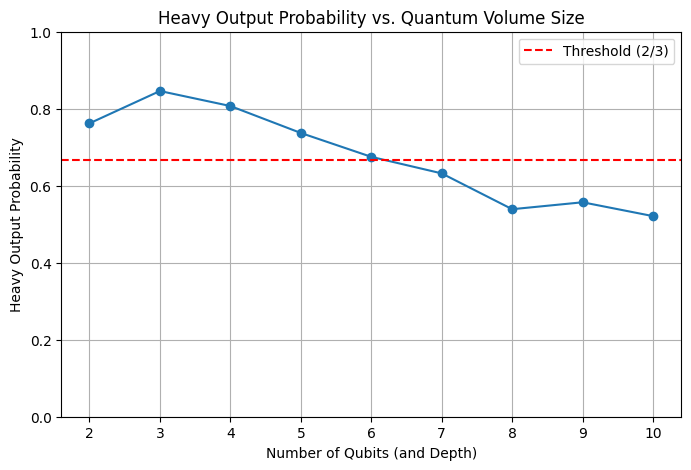

In [ ]:
######################### Quantum Volume (3) #########################


nQubits = 10; # number of qubits
heavy_output_probs = []; # keep track of the heavy output probabilities
shots = 1000; # run the circuit 1000 times

for n in range(2, nQubits + 1):
    print(f"\n--- Running QV for {n} qubits/depth ---")

    # Create and simulate QV circuit
    qv_circuit = create_quantum_volume_circuit(num_qubits = n, depth = n) # create the QV circuit with a lot of qubits

    # Get ideal probabilities
    state_probabilities = get_real_qv_distribution(qv_circuit) # ideal probabilities of all the states (probability of every state output when there is no noise)

    # Compute heavy outputs
    median = np.median(list(state_probabilities.values()))
    heavy_outputs = {bit for bit, prob in state_probabilities.items() if prob > median} # get the heavy output bits
    heavy_counts = sum(state_probabilities.get(bit, 0) for bit in heavy_outputs); # count the number of times each heavy output bit was recorded
    heavy_prob = heavy_counts / shts; # probability of the heavy outputs
    heavy_output_probs.append(heavy_prob);

    #print(f"Heavy Output Probability : \t{heavy_prob:.4f}\n\n");

# Plot results
plt.figure(figsize = (8, 5))
plt.plot(range(2, nQubits + 1), heavy_output_probs, marker='o')
plt.axhline(2 / 3, color='r', linestyle='--', label='Threshold (2/3)')
plt.title("Heavy Output Probability vs. Quantum Volume Size")
plt.xlabel("Number of Qubits (and Depth)")
plt.ylabel("Heavy Output Probability")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.show()



# Simulation Time v. Number of Qubits Between Ideal QPU and IBM's Brisbane QPU

In [38]:
#################### QV Time on Ideal QPU v. Real QPU ####################

import time


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential_model(n, a, b):
    return a * (2 ** (b * n))

def measure_qv_simulation_time(min_qubits, max_qubits, repeats, extrapolate_to): # measuring the time it takes to compute the heavy output probabilities on an ideal QPU

    sim_times = []
    sim_stds = []
    qubit_range = range(min_qubits, max_qubits + 1)

    for n in qubit_range: # simulate the QV circuit for larger and larger number of qubits
        #print(f"\n⏳ Simulating QV circuit with {n} qubits x {n} depth...")

        times = [] # track how much time it took run the QV circuit

        for _ in range(repeats):

            qv_circuit = create_quantum_volume_circuit(nQubits = n, Depth = n) # create the QV circuit

            start = time.time() # start the timer
            _ = get_ideal_qv_distribution(qv_circuit) # calculate heavy output probabilities for ideal circuit
            elapsed = time.time() - start # end the timer
            del _;
            times.append(elapsed)

        avg_time = np.mean(times) # get the average amount of time to complete a QV circuit
        std_time = np.std(times) # get the standard deviation of the time to complete a QV circuit

        sim_times.append(avg_time) # store the average time
        sim_stds.append(std_time) # store the standard deviation

        #print(f"Avg simulation time for {n} qubits: {avg_time:.3f}s ± {std_time:.3f}s")

    # Fit exponential model
    x_data = np.array(list(qubit_range))
    y_data = np.array(sim_times)
    popt, _ = curve_fit(exponential_model, x_data, y_data, p0=(1e-6, 1.0))

    # Extrapolate
    extrapolated_time = exponential_model(extrapolate_to, *popt)
    print(f"\n⏩ Extrapolated simulation time for {extrapolate_to} qubits: {extrapolated_time:.3e} seconds")

    # Plot with error bars and exponential fit
    x_fit = np.linspace(min_qubits, extrapolate_to, 200)
    y_fit = exponential_model(x_fit, *popt)
    age_of_univrese = 4.351968e+17 * numpy.ones(200);


    plt.figure(figsize=(9, 6))
    plt.errorbar(x_data, y_data, yerr=sim_stds, fmt='ob', capsize=5, label="Measured Times")
    plt.xlim(min(x_fit), max(x_fit))

    plt.plot(x_fit, y_fit, color = 'red')
    plt.plot(x_fit, age_of_univrese, color = 'black', label = "age of the universe");
    plt.scatter([extrapolate_to], [extrapolated_time], color = 'red')

    plt.yscale("log")
    plt.xlabel("Number of Qubits (and Depth)")
    plt.ylabel("Avg Simulation Time (seconds, log scale)")
    plt.title("QV Simulation Time vs. Qubit Count (with Exponential Fit)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def measure_qv_real_simulation_time(min_qubits, max_qubits, repeats, extrapolate_to): # same thing - measuring the time it takes to compute the heavy output probabilities - except on a real QPU

    sim_times = []
    sim_stds = []
    qubit_range = range(min_qubits, max_qubits + 1)

    for n in qubit_range:
        #print(f"\n⏳ Simulating QV circuit with {n} qubits x {n} depth...")

        times = []
        for _ in range(repeats):

            qv_circuit = create_quantum_volume_circuit(nQubits = n, Depth = n) # create the QV circuit

            start = time.time() # start the timer
            _ = get_real_qv_distribution(qv_circuit) # runt he QV circuit on a real QPU
            elapsed = time.time() - start # stop the timer
            del _ # delete the simulated data since we do not need it for this exercise
            times.append(elapsed) # record the elapsed time

        avg_time = np.mean(times)
        std_time = np.std(times)

        sim_times.append(avg_time)
        sim_stds.append(std_time)

        #print(f"Avg simulation time for {n} qubits: {avg_time:.3f}s ± {std_time:.3f}s")

    # Fit exponential model
    x_data = np.array(list(qubit_range))
    y_data = np.array(sim_times)
    popt, _ = curve_fit(exponential_model, x_data, y_data, p0=(1e-6, 1.0))

    # Extrapolate
    extrapolated_time = exponential_model(extrapolate_to, *popt)
    print(f"\n⏩ Extrapolated simulation time for {extrapolate_to} qubits: {extrapolated_time:.3e} seconds")

    # Plot with error bars and exponential fit
    x_fit = np.linspace(min_qubits, extrapolate_to, 200)
    y_fit = exponential_model(x_fit, *popt)
    age_of_univrese = 4.351968e+17 * numpy.ones(200);


    plt.figure(figsize=(9, 6))
    plt.errorbar(x_data, y_data, yerr=sim_stds, fmt='ob', capsize=5, label="Measured Times")
    plt.xlim(min(x_fit), max(x_fit))

    plt.plot(x_fit, y_fit, color = 'red')
    plt.plot(x_fit, age_of_univrese, color = 'black', label = "age of the universe");
    plt.scatter([extrapolate_to], [extrapolated_time], color = 'red')

    plt.yscale("log")
    plt.xlabel("Number of Qubits (and Depth)")
    plt.ylabel("Avg Simulation Time (seconds, log scale)")
    plt.title("QV Simulation Time vs. Qubit Count (with Exponential Fit)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()



⏩ Extrapolated simulation time for 100 qubits: 4.858e+29 seconds


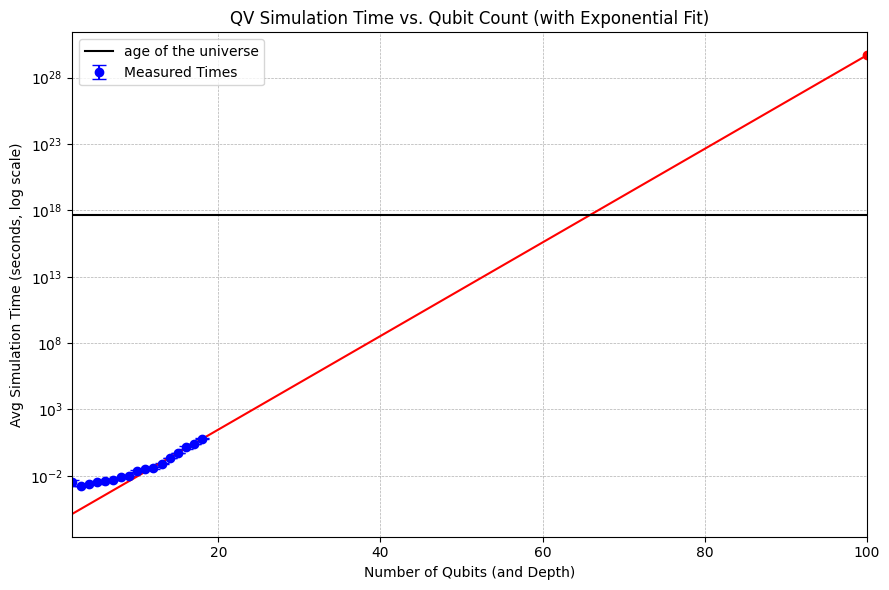

In [37]:
#################### QV Time on Ideal QPU ####################

measure_qv_simulation_time(min_qubits = 2, max_qubits = 18, repeats = 3, extrapolate_to = 100);  # measure the average time taken to compute heavy outputs probabilities on a ideal QPU

In [ ]:
#################### QV Time on Real QPU ####################

measure_qv_real_simulation_time(min_qubits =  2, max_qubits = 18, repeats = 3, extrapolate_to = 100); # measure the average time taken to compute heavy outputs probabilities on a real QPU